Reference: https://mc-stan.org/docs/stan-users-guide/QR-reparameterization.html  
Dataset: https://www.kaggle.com/datasets/mirichoi0218/insurance

In [1]:
import stan
import numpy as np
import matplotlib.pyplot as plt
import nest_asyncio; nest_asyncio.apply()
import pandas as pd; pd.set_option("mode.chained_assignment", None)
from utils import select_columns, plot_ESS, plot_GR, plot_posterior

df = pd.read_csv("../data/insurance.csv")
display(df)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [2]:
df_normalised = df.drop(columns=["sex", "smoker", "region"])
df_normalised["sex(male=1)"] = np.float64(df["sex"] == "male")
df_normalised["smoker(yes=1)"] = np.float64(df["smoker"] == "yes")
df_normalised = (df_normalised - df_normalised.mean()) / df_normalised.std()
display(df_normalised)

,age,bmi,children,charges,sex(male=1),smoker(yes=1)
0,-1.438227,-0.453151,-0.908274,0.298472,-1.010141,1.969850
1,-1.509401,0.509431,-0.078738,-0.953333,0.989221,-0.507273
2,-0.797655,0.383164,1.580335,-0.728402,0.989221,-0.507273
3,-0.441782,-1.305043,-0.908274,0.719574,0.989221,-0.507273
4,-0.512957,-0.292447,-0.908274,-0.776512,0.989221,-0.507273
...,...,...,...,...,...,...
1333,0.768185,0.050278,1.580335,-0.220468,0.989221,-0.507273
1334,-1.509401,0.206062,-0.908274,-0.913661,-1.010141,-0.507273
1335,-1.509401,1.014499,-0.908274,-0.961237,-1.010141,-0.507273
1336,-1.295877,-0.797515,-0.908274,-0.930014,-1.010141,-0.507273


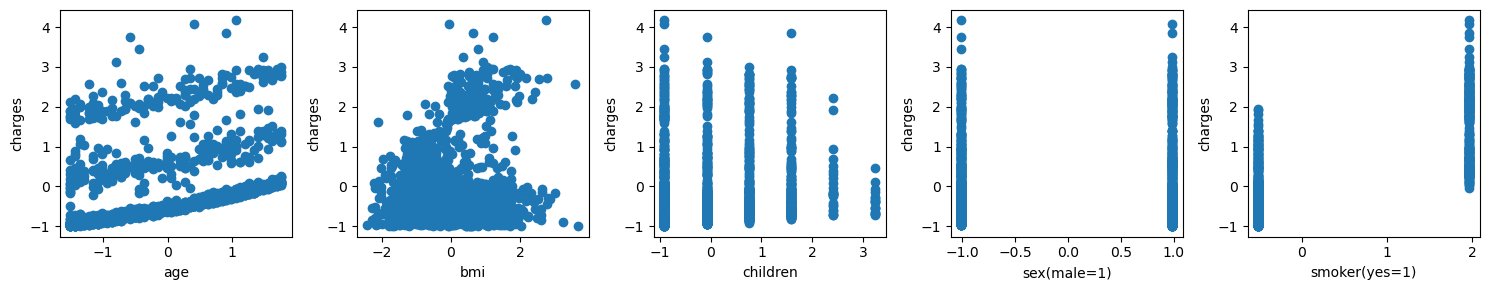

In [3]:
x_labels = df_normalised.columns.drop("charges")
fig, axes = plt.subplots(1, len(x_labels), figsize=(len(x_labels) * 3, 3))
for i, x in enumerate(x_labels):
    axes[i].scatter(df_normalised[x], df_normalised["charges"])
    axes[i].set_xlabel(x)
    axes[i].set_ylabel("charges")
plt.tight_layout()
plt.show()

In [4]:
num_chains = 20
num_samples = 2000
data = {"N": len(df_normalised),
        "K": len(x_labels),
        "x": df_normalised[x_labels].to_numpy(),
        "y": df_normalised["charges"].to_numpy()}

In [109]:
insurance_fee_nonqr = """
data {
  int<lower=0> N;   // number of data items
  int<lower=0> K;   // number of predictors
  matrix[N, K] x;   // predictor matrix
  vector[N] y;      // outcome vector
}
parameters {
  real alpha;           // intercept
  vector[K] beta;       // coefficients on x
  real<lower=0> sigma;  // error scale
}
model {
  // prior
  alpha ~ normal(0, 1);
  beta ~ normal(0, 1);
  sigma ~ lognormal(0, 1);

  // likelihood
  y ~ normal(x * beta + alpha, sigma);
}
"""

posterior_nonqr = stan.build(insurance_fee_nonqr, data=data)
fit_nonqr = posterior_nonqr.sample(num_chains=num_chains, num_samples=num_samples)
df_nonqr = fit_nonqr.to_frame()
df_nonqr.to_csv("result/insurance_fee_nonqr.csv")

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   5% (3000/60000)
Sampling:  10% (6000/60000)
Sampling:  15% (9000/60000)
Sampling:  20% (12000/60000)
Sampling:  25% (15000/60000)
Sampling:  30% (18000/60000)
Sampling:  35% (21000/60000)
Sampling:  40% (24000/60000)
Sampling:  45% (27000/60000)
Sampling:  50% (30000/60000)
Sampling:  55% (33000/60000)
Sampling:  60% (36000/60000)
Sampling:  65% (39000/60000)
Sampling:  70% (42000/60000)
Sampling:  75% (45000/60000)
Sampling:  80% (48000/60000)
Sampling:  85% (51000/60000)
Sampling:  90% (54000/60000)
Sampling:  95% (57000/60000)
Sampling: 100% (60000/60000)
Sampling: 100% (60000/60000), done.
Messages received during sampling:
  Gradient evaluation took 0.000181 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.81 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000167 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.67 seconds.
  Adjust yo

In [110]:
insurance_fee_qr = """
data {
  int<lower=0> N;   // number of data items
  int<lower=0> K;   // number of predictors
  matrix[N, K] x;   // predictor matrix
  vector[N] y;      // outcome vector
}
transformed data {
  matrix[N, K] Q_ast;
  matrix[K, K] R_ast;
  matrix[K, K] R_ast_inverse;
  // thin and scale the QR decomposition
  Q_ast = qr_thin_Q(x) * sqrt(N - 1);
  R_ast = qr_thin_R(x) / sqrt(N - 1);
  R_ast_inverse = inverse(R_ast);
}
parameters {
  real alpha;           // intercept
  vector[K] beta_hat;   // coefficients on Q_ast
  real<lower=0> sigma;  // error scale
}
model {
  // prior
  alpha ~ normal(0, 1);
  R_ast_inverse * beta_hat ~ normal(0, 1);      // beta ~ normal(0, 1);
  sigma ~ lognormal(0, 1);

  // likelihood
  y ~ normal(Q_ast * beta_hat + alpha, sigma);
}
generated quantities {
  vector[K] beta = R_ast_inverse * beta_hat;    // coefficients on x
}
"""

posterior_qr = stan.build(insurance_fee_qr, data=data)
fit_qr = posterior_qr.sample(num_chains=num_chains, num_samples=num_samples)
df_qr = fit_qr.to_frame()
df_qr.to_csv("result/insurance_fee_qr.csv")

Building...

In file included from /home/sangho/anaconda3/envs/ppl/lib/python3.9/site-packages/httpstan/include/stan/model/indexing.hpp:5,
                 from /home/sangho/anaconda3/envs/ppl/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:17,
                 from /home/sangho/.cache/httpstan/4.8.2/models/qipfelfy/model_qipfelfy.cpp:2:
/home/sangho/anaconda3/envs/ppl/lib/python3.9/site-packages/httpstan/include/stan/model/indexing/assign_varmat.hpp: In function ‘void stan::model::assign(Mat1&&, const Mat2&, const char*, const stan::model::index_multi&, const stan::model::index_multi&)’:
/home/sangho/anaconda3/envs/ppl/lib/python3.9/site-packages/httpstan/include/stan/model/indexing/assign_varmat.hpp:401:9: warning: typedef ‘using pair_type = struct std::pair<int, std::vector<int, stan::math::arena_allocator<int> > >’ locally defined but not used [-Wunused-local-typedefs]
  401 |   using pair_type = std::pair<int, arena_vec>;
      |         ^~~~~~~~~
/home/sangho/.cache/h


Building: 21.3s, done.Messages from stanc:
Warning in '/tmp/httpstan_cg22v3nq/model_qipfelfy.stan', line 25, column 2: Left-hand
    side of sampling statement (~) may contain a non-linear transform of a
    parameter or local variable. If it does, you need to include a target +=
    statement with the log absolute determinant of the Jacobian of the
    transform.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   5% (3000/60000)
Sampling:  10% (6000/60000)
Sampling:  15% (9000/60000)
Sampling:  20% (12000/60000)
Sampling:  25% (15000/60000)
Sampling:  30% (18000/60000)
Sampling:  35% (21000/60000)
Sampling:  40% (24000/60000)
Sampling:  45% (27000/60000)
Sampling:  50% (30000/60000)
Sampling:  55% (33000/60000)
Sampling:  60% (36000/60000)
Sampling:  65% (39000/60000)
Sampling:  70% (42000/60000)
Sampling:  75% (45000/60000)
Sampling:  80% (48000/60000)
Sampling:  85% (51000/60000)
Sampling:  90% (54

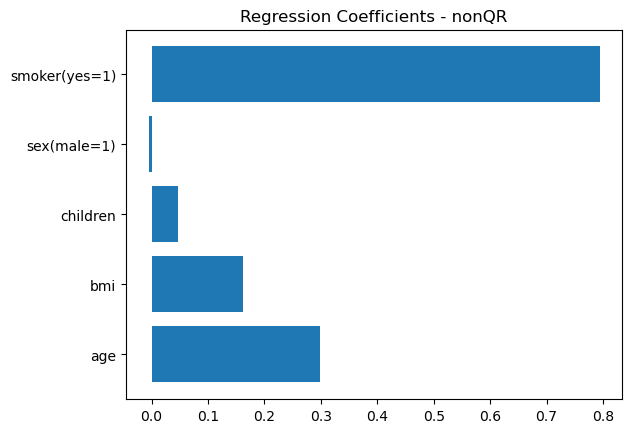

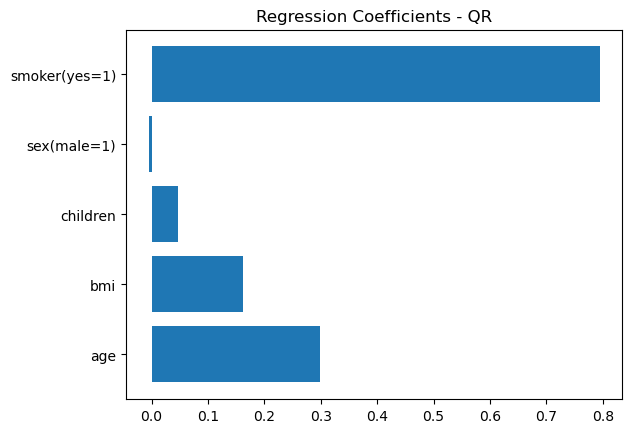

In [5]:
df_nonqr = pd.read_csv("result/insurance_fee_nonqr.csv")
df_qr = pd.read_csv("result/insurance_fee_qr.csv")
dfs = [df_nonqr, df_qr]
labels = ["nonQR", "QR"]

for df, label in zip(dfs, labels):
    mean = select_columns(df, "beta.").mean(axis=0).to_numpy()
    std = select_columns(df, "beta.").std(axis=0).to_numpy()
    plt.barh(x_labels, mean)
    plt.title(f"Regression Coefficients - {label}")
    plt.show()

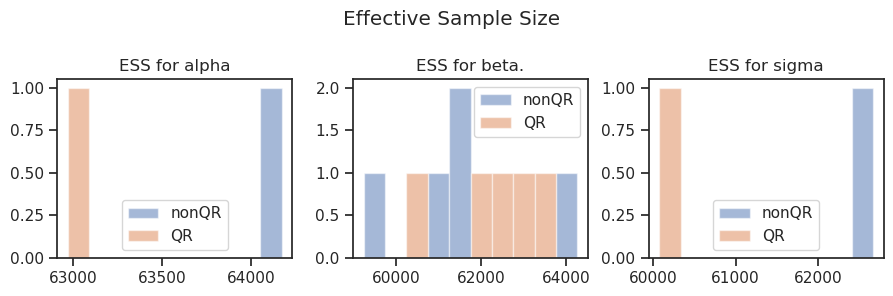

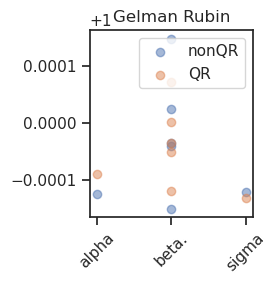

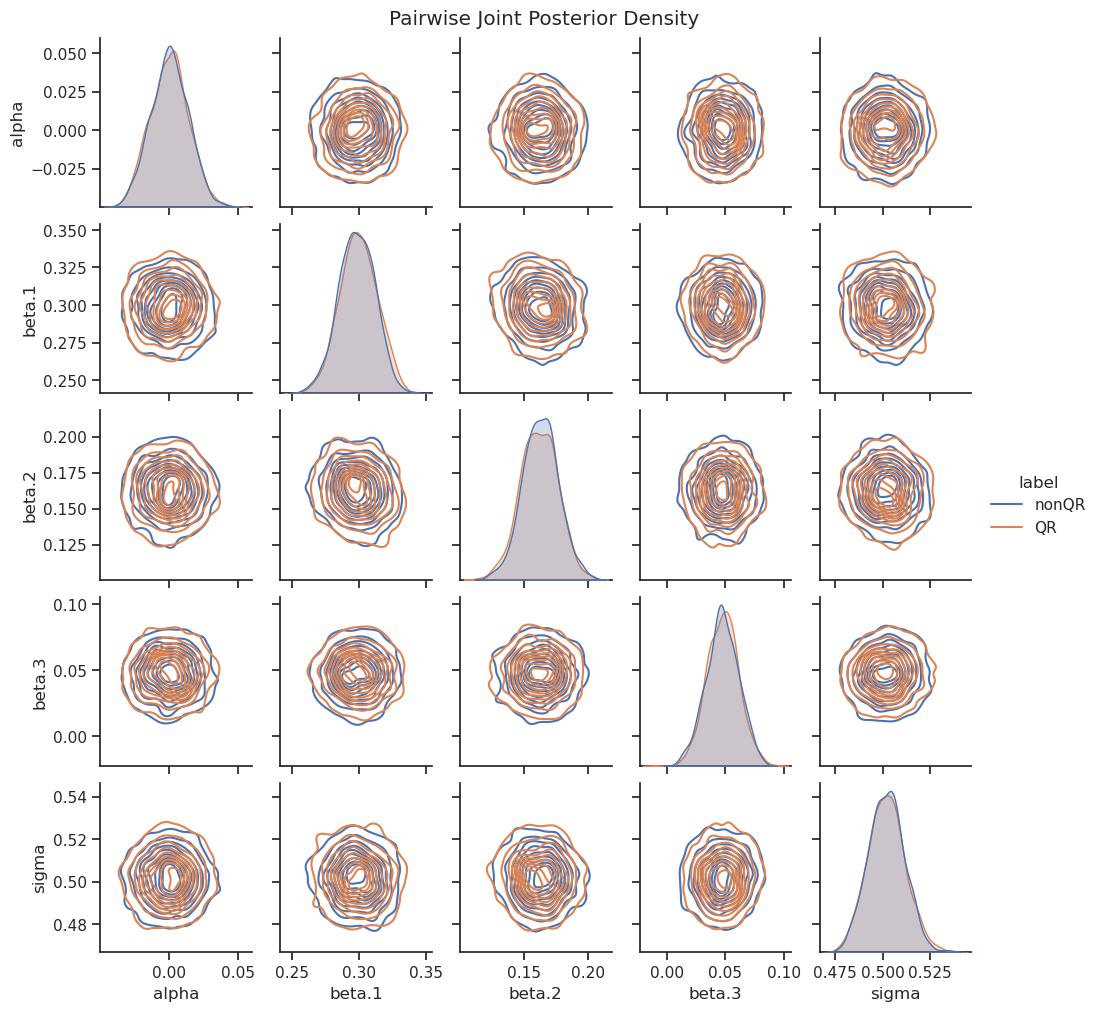

In [10]:
plot_ESS(dfs, labels,
         params=["alpha", "beta.", "sigma"],
         num_chains=num_chains, num_samples=num_samples)

plot_GR(dfs, labels,
        params=["alpha", "beta.", "sigma"],
        num_chains=num_chains, num_samples=num_samples)

plot_posterior(dfs, labels,
               params=["alpha", "beta.1", "beta.2", "beta.3", "sigma"],
               num_subsamples=1000)